In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
import transformers
import torch
import random
import torch.optim as optim
import higher
import time
import os

D:\Anaconda\envs\Grid\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Credits
## This cell includes code from StylePTB (https://github.com/lvyiwei1/StylePTB/tree/master) by Yiwei Lyu et al., 
## available under the Creative Commons Attribution 4.0 International License ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)).

def lowering(pairs):
    for pair in pairs:
        for i in range(0, 2):
            pair[i] = pair[i].lower()

def numpreprocess(pairs):
    for pair in pairs:
        for i in range(0, 2):
            rep = []
            for word in pair[i].split(' '):
                if len(word) > 0 and word[0] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
                    rep.append("NUM")
                else:
                    rep.append(word)
            pair[i] = ' '.join(rep)

def padinput(inputlist, totalpad=80):
    pads = [0] * (totalpad - len(inputlist))
    input = inputlist + pads
    mask = [1] * len(inputlist) + pads
    return input, mask

# create label for training
def labels(inlen, outputlist, totalpad=80):
    pads1 = [-100] * inlen
    pads2 = [-100] * (totalpad - inlen - len(outputlist))
    # print(outputlist)
    return pads1 + outputlist + pads2

def batchvalid(src, trg, batchsize):
    validloss = 0.0
    for i in range(0, len(src) // batchsize):
        asrc = []
        atrg = []
        for pair in src[i * batchsize:(i + 1) * batchsize]:
            asrc.append(pair)
        for pair in trg[i * batchsize:(i + 1) * batchsize]:
            atrg.append(pair)
        validloss += valid(asrc, atrg)
    return validloss / (len(src) // batchsize)

def valid(src, trg):
    padin = [padinput(l) for l in src]
    padedin = torch.LongTensor([padin[i][0] for i in range(0, len(trg))]).to(device)
    masks = torch.LongTensor([padin[i][1] for i in range(0, len(trg))]).to(device)
    label = torch.LongTensor([labels(len(src[i]), trg[i]) for i in range(0, len(trg))]).to(device)
    with torch.no_grad():
        ret = gpt_model.forward(padedin, attention_mask=masks, labels=label)
        loss = ret[0]
    return loss

In [3]:
class MAML_GPT():
    def __init__(self, gpt_model, tasks, device, gpt_tokenizer=None, inner_lr=2e-4, meta_lr=2e-5, K=10, query_size=10, 
                 multi_batch_iter=1, inner_steps=1, early_stop=300, model_save_name="maml_gpt", print_time_mem=False):
        self.tasks = tasks
        self.model = gpt_model
        self.gpt_tokenizer = gpt_tokenizer
        #self.criterion = nn.MSELoss()
        self.meta_optimiser = optim.Adam(self.model.parameters(), meta_lr)
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps
        self.plot_every = 10
        self.print_every = 100
        self.meta_losses = []
        self.early_stop = early_stop
        self.meta_batch_size = len(tasks)
        self.model_save_name = model_save_name
        self.multi_batch_iter = multi_batch_iter
        self.device = device
        self.query_size = query_size
        self.print_time_mem = print_time_mem
        
    def inner_loop(self, task):
        self.inner_loop_counter += 1

        if self.print_time_mem:
            start_inner_time = time.time()  
            if torch.cuda.is_available():
                start_inner_mem = torch.cuda.memory_allocated()
            print(f"Start inner loop {self.inner_loop_counter}.")
            print(f"Current memory used: {(start_inner_mem) / (1024 ** 2)} MB.")
    
        with higher.innerloop_ctx(self.model, self.inner_opt, copy_initial_weights=False) as (fmodel, diffopt):

            if self.print_time_mem:
                copy_time = time.time()
                if torch.cuda.is_available():
                    copy_mem = torch.cuda.memory_allocated() 
                print(f"Copy model.")    
                print(f"Time taken: {copy_time - start_inner_time} seconds; Memory used: {(copy_mem - start_inner_mem) / (1024 ** 2)} MB.")
        
            random_selected_samples = random.sample(task, self.K + self.query_size)
            inner_train_samples = random_selected_samples[:self.K]
            inner_test_samples = random_selected_samples[self.K:]
            padedin, masks, labels = self.samples_to_padedin_masks_labels(inner_train_samples)
            for step in range(self.inner_steps):
                pred = fmodel(padedin, attention_mask=masks, labels=labels)
                loss_inner_step = pred[0]
                diffopt.step(loss_inner_step)
                del pred

            if self.print_time_mem:
                end_inner_train_time = time.time()
                if torch.cuda.is_available():
                    end_inner_train_mem = torch.cuda.memory_allocated() 
                print(f"Finish training copied model.")    
                print(f"Time taken: {end_inner_train_time - copy_time} seconds; Memory used: {(end_inner_train_mem - copy_mem) / (1024 ** 2)} MB.")
        
            padedin, masks, labels = self.samples_to_padedin_masks_labels(inner_test_samples)
            pred = fmodel(padedin, attention_mask=masks, labels=labels)
            loss = pred[0]
            loss.backward()
            loss_item = loss.detach().item()

            if self.print_time_mem:
                end_inner_test_time = time.time()
                if torch.cuda.is_available():
                    end_inner_test_mem = torch.cuda.memory_allocated()
                print(f"Finish testing copied model.")    
                print(f"Time taken: {end_inner_test_time - end_inner_train_time} seconds; Memory used: {(end_inner_test_mem - end_inner_train_mem) / (1024 ** 2)} MB.")

            del pred
            del fmodel
            del diffopt
            
            if self.print_time_mem:
                end_inner_del_time = time.time()
                if torch.cuda.is_available():
                    end_inner_del_mem = torch.cuda.memory_allocated() 
                print(f"Release Memory.")    
                print(f"Time taken: {end_inner_del_time - end_inner_test_time} seconds; Memory used: {(end_inner_del_mem - end_inner_test_mem) / (1024 ** 2)} MB.")

            return loss_item
    
    def main_loop(self, num_iterations):
        min_loss = 999
        min_epoch = -1
        early_stop_count = 0
        print_loss = 0
        plot_loss = 0
        saved_models = []
        for iteration in range(1, num_iterations + 1):
            self.main_loop_counter = iteration

            if self.print_time_mem:
                start_main_time = time.time()
                if torch.cuda.is_available():
                    start_main_mem = torch.cuda.memory_allocated() 
                print()
                print(f"Start main loop epoch {iteration}.")
                print(f"Current memory used: {(start_main_mem) / (1024 ** 2)} MB.")

            self.meta_optimiser.zero_grad()
            self.inner_opt = torch.optim.SGD(self.model.parameters(), lr=self.inner_lr)
            meta_loss = 0
            self.inner_loop_counter = 0
            for _ in range(self.multi_batch_iter):
                for task in self.tasks:
                    meta_loss += self.inner_loop(task)
            meta_loss = meta_loss / (self.meta_batch_size * self.multi_batch_iter)
            if meta_loss < min_loss:
                min_loss = meta_loss
                min_epoch = iteration
                early_stop_count = 0
                #print(f"New lowest loss ({meta_loss}) found at Epoch {iteration}!")
                save_path = f".\\MAML_GPT_models\\{self.model_save_name}_epoch{iteration}.pt"
                torch.save(self.model, save_path)
                saved_models.append(save_path)
                if len(saved_models) > 5:
                    oldest_model = saved_models.pop(0) 
                    os.remove(oldest_model)
            else:
                early_stop_count += 1
                if early_stop_count > self.early_stop:
                    print(f"Early stop at epoch {iteration} because no lower loss is found in {self.early_stop} epochs")
                    print(f"The lowest loss: {min_loss}")
                    print(f"The lowest loss found at Epoch {min_epoch}")
                    return

            if self.print_time_mem:
                finish_all_inner_time = time.time()
                if torch.cuda.is_available():
                    finish_all_inner_mem = torch.cuda.memory_allocated()
                print(f"Finish all inner loops in this epoch.")    
                print(f"Time taken: {finish_all_inner_time - start_main_time} seconds; Memory used: {(finish_all_inner_mem - start_main_mem) / (1024 ** 2)} MB.")
            
            #self.meta_optimiser.zero_grad()
            #meta_loss.backward()
            self.meta_optimiser.step()

            if self.print_time_mem:
                finish_meta_update_time = time.time()
                if torch.cuda.is_available():
                    finish_meta_update_mem = torch.cuda.memory_allocated() 
                print(f"Finish meta update in this epoch.")    
                print(f"Time taken: {finish_meta_update_time - finish_all_inner_time} seconds; Memory used: {(finish_meta_update_mem - finish_all_inner_mem) / (1024 ** 2)} MB.")
            
            print_loss += meta_loss 
            plot_loss += meta_loss 
            if iteration % self.print_every == 0:
                print(f"Epoch {iteration}/{num_iterations}. loss: {print_loss / self.print_every}")
                print_loss = 0
            if iteration % self.plot_every == 0:
                self.meta_losses.append(plot_loss / self.plot_every)
                plot_loss = 0
        print(f"The lowest loss: {min_loss}")
        print(f"The lowest loss is found at Epoch {min_epoch}")

    def start_train(self, epochs=10000):
        self.epochs = epochs
        self.main_loop(self.epochs)

    def samples_to_padedin_masks_labels(self, samples):
        src = []
        trg = []
        for sample in samples:
            src.append(sample[0])
            trg.append(sample[1])
        padin = [self.padinput(l) for l in src]
        padedin = torch.LongTensor([padin[i][0] for i in range(0, len(trg))]).to(self.device)
        masks = torch.LongTensor([padin[i][1] for i in range(0, len(trg))]).to(self.device)
        labels = torch.LongTensor([self.create_labels(len(src[i]), trg[i]) for i in range(0, len(trg))]).to(self.device)
        return padedin, masks, labels

    def create_labels(self, inlen, outputlist, totalpad=80):
        pads1 = [-100] * inlen
        pads2 = [-100] * (totalpad - inlen - len(outputlist))
        return pads1 + outputlist + pads2
    
    def padinput(self, inputlist, totalpad=80):
        pads = [0] * (totalpad - len(inputlist))
        input = inputlist + pads
        mask = [1] * len(inputlist) + pads
        return input, mask

In [4]:
# Load pre-trained model and tokenizer
# Pre-process the data

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f"Device: {device}")
gpt_tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = transformers.GPT2LMHeadModel.from_pretrained('gpt2').to(device)
meta_train_task_name_list = ["ARR", "TFU", "ATP", "PPR", "TPA"]
meta_test_task_name_list = ["PTA", "SBR", "TPR"]

train_task_pair_list = [] # Nested list with pairs from different tasks
for meta_train_task_name in meta_train_task_name_list:
    f = open(f'.\\Data\\Meta_training\\{meta_train_task_name}\\train.tsv', 'r')
    ff = csv.reader(f, delimiter='\t')
    pairs = []
    for row in ff:
        pairs.append(row)
    lowering(pairs)
    numpreprocess(pairs)
    pairsEncode = []
    for i in pairs:
        pairsEncode.append((gpt_tokenizer.encode(i[0] + " <|endoftext|>"), gpt_tokenizer.encode(i[1] + " <|endoftext|>")))
    train_task_pair_list.append(pairsEncode)

Device: cuda:0


In [5]:
maml_gpt = MAML_GPT(gpt_model=gpt_model, tasks=train_task_pair_list, device = device, gpt_tokenizer=gpt_tokenizer, 
                    multi_batch_iter=1, query_size=20, model_save_name="maml_gpt", print_time_mem=False)

In [6]:
maml_gpt.start_train(10000)

Epoch 5/50. loss: 8.669212932586671
Epoch 10/50. loss: 6.792773475646973
Epoch 15/50. loss: 5.94089952468872
Epoch 20/50. loss: 5.043144168853759
Epoch 25/50. loss: 4.883031454086304
Epoch 30/50. loss: 4.793969783782959
Epoch 35/50. loss: 4.4950209331512445
Epoch 40/50. loss: 4.213452882766724
Epoch 45/50. loss: 4.3282711315155025
Epoch 50/50. loss: 4.09408618927002
The lowest loss: 3.6936896324157713
The lowest loss is found at Epoch 41


Text(0, 0.5, 'Loss')

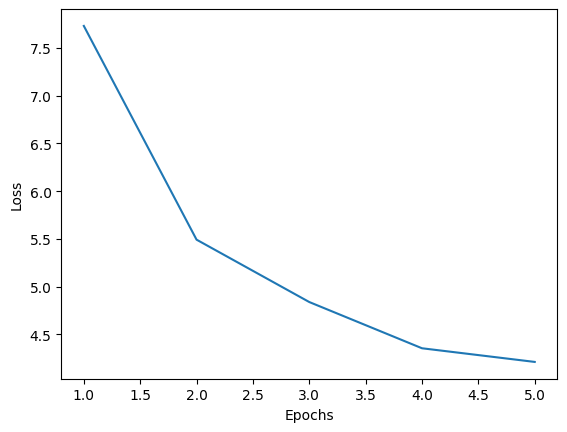

In [14]:
plt.plot(range(1, len(maml_gpt.meta_losses) + 1), maml_gpt.meta_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")